In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from scipy import stats

from utils.analysis import linear_correlation_plot, bland_altman_plot

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
# define a function for calculating two-way RMS CV
def calculate_two_way_RMS_CV(data1,data2):
    
    EPS = 1e-8
    
    data1, data2 = np.asarray(data1), np.asarray(data2)
    
    m = len(data1)
    
    n = 2 # number of repeat scans
    
    data_mean = (data1+data2)/2
    
    # calculate square of residuals for each set of measurements
    data1_sq_res = (data1 - data_mean)**2
    data2_sq_res = (data2 - data_mean)**2
    
    # standard deviation of the data
    data_std = np.sqrt((data1_sq_res+data2_sq_res)/(n-1))
    
    # RMS precision error
    RMS_PE = np.sqrt(np.sum(data_std**2)/m)
    
    # Least significant change
    LSC = 2.77*RMS_PE
    
    # RMS Coefficient of Variation
    RMS_CV = np.sqrt(np.sum((100*data_std/(data_mean+EPS))**2)/m)
    
    return RMS_CV, LSC
    
    

In [5]:
# CONSTANTS
ALPHA = 0.05
MOTION_SCORE_MAX = 3

In [6]:
# Predicted data conversion key and columns to drop

col_drop = [
    'Meas',
    'MeasDate',
    'Patient',
    'Site'
]
    
col_conv = {
    'Filename': 'label',
    'BA.CtAr': 'BA.Ct.Ar [mm^2]',
    'BA.TtAr': 'BA.Tot.Ar [mm^2]',
    'BA.TbAr': 'BA.Tb.Ar [mm^2]',
    'BMD': 'Tt.BMD [mg HA / cm^3]',
    'BVTV': 'Tb.BV/TV [%]',
    'ConnD': 'Conn.D [1/mm^3]',
    'CtAr': 'Ct.Ar [mm^2]',
    'CtBMD': 'Ct.BMD [mg HA / cm^3]',
    'CtPm': 'Ct.Pm [mm]',
    'CtPo': 'Ct.Po [%]',
    'CtPoDm': 'Ct.Po.Dm [mm]',
    'CtTMD': 'Ct.TMD [mg HA / cm^3]',
    'CtTh': 'Ct.Th [mm]',
    'DA': 'DA [-]',
    'SMI': 'SMI [-]',
    'TMD': 'Tot.TMD [mg Ha / cm^3]',
    'Tb1NSD': 'Tb.1/N.SD [mm]',
    'TbAr': 'Tb.Ar [mm^2]',
    'TbBMD': 'Tb.BMD [mg HA / cm^3]',
    'TbN': 'Tb.N [1/mm]',
    'TbSp': 'Tb.Sp [mm]',
    'TbTMD': 'Tb.TMD [mg HA / cm^3]',
    'TbTh': 'Tb.Th [mm]',
    'TtAr': 'Tt.Ar [mm^2]',
}

Import the precision dataset, drop and convert column headers

In [7]:
df = pd.read_csv('eval_logs/unet_precision_logs/registered/data.csv')

# get rid of all of the useless unit columns
keep_columns = [col for col in df.columns if 'units' not in col]
df = df[keep_columns].copy()

# drop the unneeded columns and rename the others
df.drop(col_drop,axis=1,inplace=True)
df = df.rename(columns=col_conv)

# parse the label column into an ID column and a scan number column
df['ID'] = df['label'].apply(lambda x: x[3:-3])
df['scan'] = df['label'].apply(lambda x: int(x[-1]))

# get list of unique IDs
ID_list = set(list(df['ID']))
print(f'There are {len(ID_list)} unique IDs in the dataset')

# build a new dataframe where there is a single row for each ID and one entry 
# for each analysis output for each scan
df_dict = {}
df_dict['ID'] = []
for s in [1,2]:
    for v in col_conv.values():
        df_dict[f'Scan {s}, {v}'] = []

for ID in ID_list:
    df_dict['ID'].append(ID)
    for s in [1,2]:
        for v in col_conv.values():
            df_dict[f'Scan {s}, {v}'].append(df[(df['ID']==ID)&(df['scan']==s)][v].iloc[0])
            
df = pd.DataFrame.from_dict(df_dict)

df['Site'] = df['ID'].apply(lambda x: x[11])



There are 179 unique IDs in the dataset


In [8]:
# finally, we need to load in the motion scores to exclude the scans where there is too much motion

motion_scores = pd.read_csv('/Users/nathanneeteson/Documents/Data/PRECX2/motion_scores.csv')

df['ID, no side'] = df['ID'].apply(lambda x: x[:-1])

motion_scores.rename({'ID': 'ID, no side'}, axis='columns', inplace=True)
motion_scores['ID, no side'].apply(lambda x: x.strip())

df = pd.merge(df, motion_scores, on='ID, no side', how='inner')


In [9]:
# now drop the images that have excessive motion

df.drop(df[df['Motion Score 1'] > MOTION_SCORE_MAX].index, inplace=True)
df.drop(df[df['Motion Score 2'] > MOTION_SCORE_MAX].index, inplace=True)

In [10]:
params_and_units = [
    ('Tt.BMD', 'mg HA / cm^3'),
    ('Ct.BMD', 'mg HA / cm^3'),
    ('Ct.Th', 'mm'),
    ('Ct.Po', '%'),
    ('Tb.BMD', 'mg HA / cm^3'),
    ('Tb.N', '1/mm'),
    ('Tb.BV/TV', '%'),
    ('Tb.Th', 'mm'),
    ('Tb.Sp', 'mm'),
    ('Tt.Ar', 'mm^2'),
    ('Ct.Ar', 'mm^2'),
    ('Tb.Ar', 'mm^2')
]

full_param_name = {
    'Tt.BMD': 'Total Bone Mineral Density',
    'Ct.BMD': 'Cortical Bone Mineral Density',
    'Ct.Th': 'Cortical Thickness',
    'Ct.Po': 'Cortical Porosity',
    'Ct.Ar': 'Cortical Area',
    'Tb.BMD': 'Trabecular Bone Mineral Density',
    'Tb.N': 'Trabecular Number',
    'Tb.BV/TV': 'Trabecular Bone Volume Fraction',
    'Tb.Th': 'Trabecular Thickness',
    'Tb.Sp': 'Trabecular Separation',
    'Tb.Ar': 'Trabecular Area',
    'Tt.Ar': 'Total Area'
}

In [11]:
hlinelength = 45

print('='*hlinelength)
print('Parameter | RMS CV    | LSC      ')
print('='*hlinelength)

for param_and_unit in params_and_units:
    
    param = param_and_unit[0]
    unit = param_and_unit[1]
    
    RMS_CV, LSC = calculate_two_way_RMS_CV(
        df[f'Scan 1, {param} [{unit}]'].values,
        df[f'Scan 2, {param} [{unit}]'].values
    )
    
    print(f'{param:9s} | {RMS_CV:8.1f}% | {LSC:6.2f} {unit}')

Parameter | RMS CV    | LSC      
Tt.BMD    |      0.4% |   3.22 mg HA / cm^3
Ct.BMD    |      0.3% |   7.64 mg HA / cm^3
Ct.Th     |      0.6% |   0.02 mm
Ct.Po     |      8.6% |   0.58 %
Tb.BMD    |      0.6% |   2.42 mg HA / cm^3
Tb.N      |      2.4% |   0.09 1/mm
Tb.BV/TV  |      0.9% |   0.51 %
Tb.Th     |      0.6% |   0.00 mm
Tb.Sp     |      1.8% |   0.04 mm
Tt.Ar     |      0.5% |   5.89 mm^2
Ct.Ar     |      0.6% |   1.43 mm^2
Tb.Ar     |      0.6% |   5.12 mm^2


Now let's load the dataset generated using semi-automated segmentation with expert correction and do all of the same pre-processing...

In [12]:
df_expert = pd.read_csv('eval_logs/precision_expert_logs/data.csv')

keep_columns = [col for col in df_expert.columns if 'units' not in col]
df_expert = df_expert[keep_columns].copy()

df_expert.drop(col_drop,axis=1,inplace=True)
df_expert = df_expert.rename(columns=col_conv)

df_expert['ID'] = df_expert['label'].apply(lambda x: x[3:-3])
df_expert['scan'] = df_expert['label'].apply(lambda x: int(x[-1]))

ID_list = set(list(df_expert['ID']))

df_expert_dict = {}
df_expert_dict['ID'] = []
for s in [1,2]:
    for v in col_conv.values():
        df_expert_dict[f'Scan {s}, {v}'] = []

for ID in ID_list:
    df_expert_dict['ID'].append(ID)
    for s in [1,2]:
        for v in col_conv.values():
            df_expert_dict[f'Scan {s}, {v}'].append(df_expert[(df_expert['ID']==ID)&(df_expert['scan']==s)][v].iloc[0])
            
df_expert = pd.DataFrame.from_dict(df_expert_dict)

df_expert.dropna(inplace=True)

df_expert['Site'] = df_expert['ID'].apply(lambda x: x[11])

df_expert['ID, no side'] = df_expert['ID'].apply(lambda x: x[:-1])

df_expert = pd.merge(df_expert, motion_scores, on='ID, no side', how='inner')

df_expert.drop(df_expert[df_expert['Motion Score 1'] > MOTION_SCORE_MAX].index, inplace=True)
df_expert.drop(df_expert[df_expert['Motion Score 2'] > MOTION_SCORE_MAX].index, inplace=True)


In [13]:
hlinelength = 45

print('='*hlinelength)
print('Parameter | RMS CV    | LSC      ')
print('='*hlinelength)

for param_and_unit in params_and_units:
    
    param = param_and_unit[0]
    unit = param_and_unit[1]
    
    RMS_CV, LSC = calculate_two_way_RMS_CV(
        df_expert[f'Scan 1, {param} [{unit}]'].values,
        df_expert[f'Scan 2, {param} [{unit}]'].values
    )
    
    print(f'{param:9s} | {RMS_CV:8.1f}% | {LSC:6.2f} {unit}')

Parameter | RMS CV    | LSC      
Tt.BMD    |      0.6% |   4.68 mg HA / cm^3
Ct.BMD    |      0.6% |  15.04 mg HA / cm^3
Ct.Th     |      0.8% |   0.03 mm
Ct.Po     |     10.8% |   0.63 %
Tb.BMD    |      0.7% |   2.77 mg HA / cm^3
Tb.N      |      2.4% |   0.09 1/mm
Tb.BV/TV  |      0.9% |   0.53 %
Tb.Th     |      0.7% |   0.00 mm
Tb.Sp     |      1.8% |   0.04 mm
Tt.Ar     |      0.5% |   3.94 mm^2
Ct.Ar     |      0.9% |   2.15 mm^2
Tb.Ar     |      0.9% |   4.68 mm^2


In [14]:
hlinelength = 70

print('='*hlinelength)
print('Parameter | RMS %CV: UNet, Expert | LSC: UNet, Expert [native units]  ')
print('='*hlinelength)

for param_and_unit in params_and_units:
    
    param = param_and_unit[0]
    unit = param_and_unit[1]
    
    RMS_CV, LSC = calculate_two_way_RMS_CV(
        df[f'Scan 1, {param} [{unit}]'].values,
        df[f'Scan 2, {param} [{unit}]'].values
    )
    
    RMS_CV_expert, LSC_expert = calculate_two_way_RMS_CV(
        df_expert[f'Scan 1, {param} [{unit}]'].values,
        df_expert[f'Scan 2, {param} [{unit}]'].values
    )
    
    
    print(f'{param:9s} |     {RMS_CV:5.1f},  {RMS_CV_expert:5.1f}     |   {LSC:5.2f}, {LSC_expert:5.2f} {unit}')

Parameter | RMS %CV: UNet, Expert | LSC: UNet, Expert [native units]  
Tt.BMD    |       0.4,    0.6     |    3.22,  4.68 mg HA / cm^3
Ct.BMD    |       0.3,    0.6     |    7.64, 15.04 mg HA / cm^3
Ct.Th     |       0.6,    0.8     |    0.02,  0.03 mm
Ct.Po     |       8.6,   10.8     |    0.58,  0.63 %
Tb.BMD    |       0.6,    0.7     |    2.42,  2.77 mg HA / cm^3
Tb.N      |       2.4,    2.4     |    0.09,  0.09 1/mm
Tb.BV/TV  |       0.9,    0.9     |    0.51,  0.53 %
Tb.Th     |       0.6,    0.7     |    0.00,  0.00 mm
Tb.Sp     |       1.8,    1.8     |    0.04,  0.04 mm
Tt.Ar     |       0.5,    0.5     |    5.89,  3.94 mm^2
Ct.Ar     |       0.6,    0.9     |    1.43,  2.15 mm^2
Tb.Ar     |       0.6,    0.9     |    5.12,  4.68 mm^2


Do some of this analysis over again but now do it separately for radius and tibia

In [15]:
site_dict = {'T': 'Tibia', 'R': 'Radius'}

for k,v in site_dict.items():
    
    print('='*hlinelength)
    print(f" {v}, N = {len(df[df['Site']==k])}")
    print('='*hlinelength)
    print('Parameter | RMS %CV: UNet, Expert | LSC: UNet, Expert [native units]  ')
    print('='*hlinelength)

    for param_and_unit in params_and_units:

        param = param_and_unit[0]
        unit = param_and_unit[1]

        RMS_CV, LSC = calculate_two_way_RMS_CV(
            df[df['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df[df['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )

        RMS_CV_expert, LSC_expert = calculate_two_way_RMS_CV(
            df_expert[df_expert['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df_expert[df_expert['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )


        print(f'{param:9s} |     {RMS_CV:5.2f},  {RMS_CV_expert:5.2f}     |   {LSC:6.3f},  {LSC_expert:6.3f} {unit}')
    
    print('='*hlinelength)
    print('')

 Tibia, N = 85
Parameter | RMS %CV: UNet, Expert | LSC: UNet, Expert [native units]  
Tt.BMD    |      0.47,   0.48     |    3.716,   3.738 mg HA / cm^3
Ct.BMD    |      0.36,   0.45     |    8.370,  10.474 mg HA / cm^3
Ct.Th     |      0.61,   0.74     |    0.026,   0.032 mm
Ct.Po     |      9.07,  11.67     |    0.760,   0.818 %
Tb.BMD    |      0.61,   0.69     |    2.791,   3.063 mg HA / cm^3
Tb.N      |      2.97,   2.98     |    0.112,   0.112 1/mm
Tb.BV/TV  |      0.83,   0.82     |    0.502,   0.521 %
Tb.Th     |      0.56,   0.67     |    0.004,   0.005 mm
Tb.Sp     |      2.21,   2.21     |    0.045,   0.045 mm
Tt.Ar     |      0.27,   0.13     |    5.626,   2.741 mm^2
Ct.Ar     |      0.37,   0.66     |    1.410,   2.421 mm^2
Tb.Ar     |      0.29,   0.16     |    4.924,   2.682 mm^2

 Radius, N = 71
Parameter | RMS %CV: UNet, Expert | LSC: UNet, Expert [native units]  
Tt.BMD    |      0.29,   0.70     |    2.514,   5.595 mg HA / cm^3
Ct.BMD    |      0.27,   0.79     |    

In [16]:
def calculate_individual_standard_deviations(x1, x2):
    x_mean = (1/2)*(x1+x2) # mean for each subject
    m = len(x1) # number of subjects, and total df in the whole dataset
    return np.sqrt(((x1-x_mean)**2 + (x2-x_mean)**2)/2)

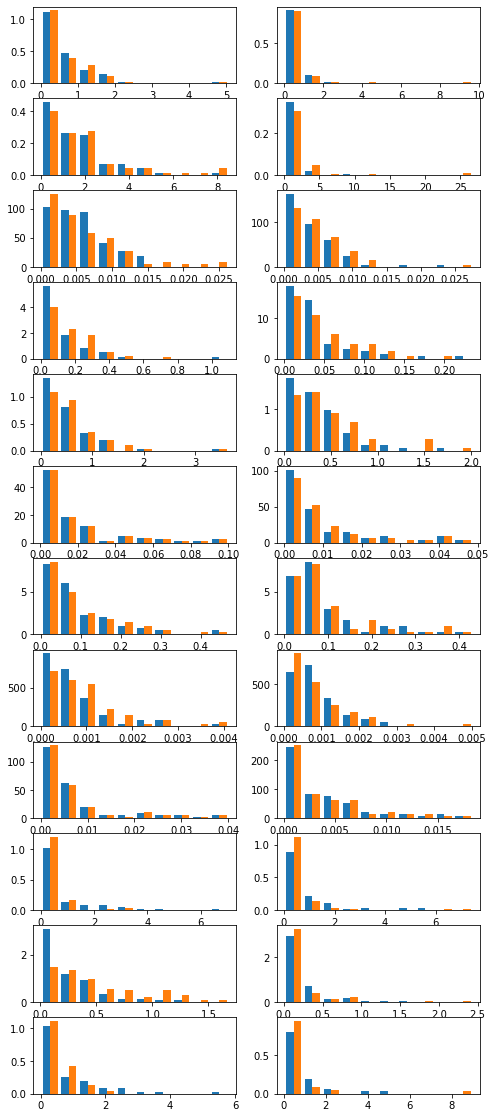

In [17]:
nrows = len(params_and_units)
ncols = len(site_dict)

fig, axs = plt.subplots(nrows, ncols, figsize=(8,20))

for (i, (k,v)) in enumerate(site_dict.items()):
    for (j, (param, unit)) in enumerate(params_and_units):

        sd = calculate_individual_standard_deviations(
            df[df['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df[df['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )

        sd_expert = calculate_individual_standard_deviations(
            df_expert[df_expert['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df_expert[df_expert['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )
        
        axs[j][i].hist((sd, sd_expert), density=True)


plt.show()

In [18]:
alpha = 0.05

for (i, (k,v)) in enumerate(site_dict.items()):
    print('')
    for (j, (param, unit)) in enumerate(params_and_units):
        
        # test for normality
        
        diff = (
            df[df['Site']==k][f'Scan 1, {param} [{unit}]'].values
            - df[df['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )
        
        (_, unet_norm_p) = stats.normaltest(diff)
        
        unet_not_norm = '*' if unet_norm_p < alpha else ' '
        
        diff_expert = (
            df_expert[df_expert['Site']==k][f'Scan 1, {param} [{unit}]'].values
            - df_expert[df_expert['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )
        
        (_, expert_norm_p) = stats.normaltest(diff)
        
        expert_not_norm = '*' if expert_norm_p < alpha else ' '

        # test for significant differences
        
        sd = calculate_individual_standard_deviations(
            df[df['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df[df['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )
        
        df_pred_temp = pd.DataFrame.from_dict(
            {
                "ID": df[df["Site"]==k]["ID"].values,
                "SD, pred": sd
            }
        )

        sd_expert = calculate_individual_standard_deviations(
            df_expert[df_expert['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df_expert[df_expert['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )
        
        df_expert_temp = pd.DataFrame.from_dict(
            {
                "ID": df_expert[df_expert['Site']==k]["ID"].values,
                "SD, expert": sd_expert
            }
        )
        
        df_combined_temp = pd.merge(df_pred_temp, df_expert_temp,on="ID")
               
        (_, p_val, _) = sm.stats.ttest_ind(df_combined_temp["SD, pred"],df_combined_temp["SD, expert"])
        
        diff_sig = "*" if p_val < alpha else " "
        print(f"{v:6s} | {param:10s} | unet norm p: {unet_norm_p:.3f} {unet_not_norm} | expert norm p: {expert_norm_p:.3f} {expert_not_norm} | diff p: {p_val:.3f} {diff_sig:s}")
        
print('')
print('Normality test  | H0: data comes from normal distribution | Ha: data does not come from normal distribution')
print('Difference test | H0: no significant difference in mean   | Ha: significant difference in mean')


Tibia  | Tt.BMD     | unet norm p: 0.000 * | expert norm p: 0.000 * | diff p: 0.991  
Tibia  | Ct.BMD     | unet norm p: 0.021 * | expert norm p: 0.021 * | diff p: 0.155  
Tibia  | Ct.Th      | unet norm p: 0.524   | expert norm p: 0.524   | diff p: 0.411  
Tibia  | Ct.Po      | unet norm p: 0.000 * | expert norm p: 0.000 * | diff p: 0.079  
Tibia  | Tb.BMD     | unet norm p: 0.000 * | expert norm p: 0.000 * | diff p: 0.430  
Tibia  | Tb.N       | unet norm p: 0.000 * | expert norm p: 0.000 * | diff p: 0.971  
Tibia  | Tb.BV/TV   | unet norm p: 0.000 * | expert norm p: 0.000 * | diff p: 0.593  
Tibia  | Tb.Th      | unet norm p: 0.000 * | expert norm p: 0.000 * | diff p: 0.126  
Tibia  | Tb.Sp      | unet norm p: 0.001 * | expert norm p: 0.001 * | diff p: 0.975  
Tibia  | Tt.Ar      | unet norm p: 0.000 * | expert norm p: 0.000 * | diff p: 0.008 *
Tibia  | Ct.Ar      | unet norm p: 0.000 * | expert norm p: 0.000 * | diff p: 0.000 *
Tibia  | Tb.Ar      | unet norm p: 0.000 * | expert n

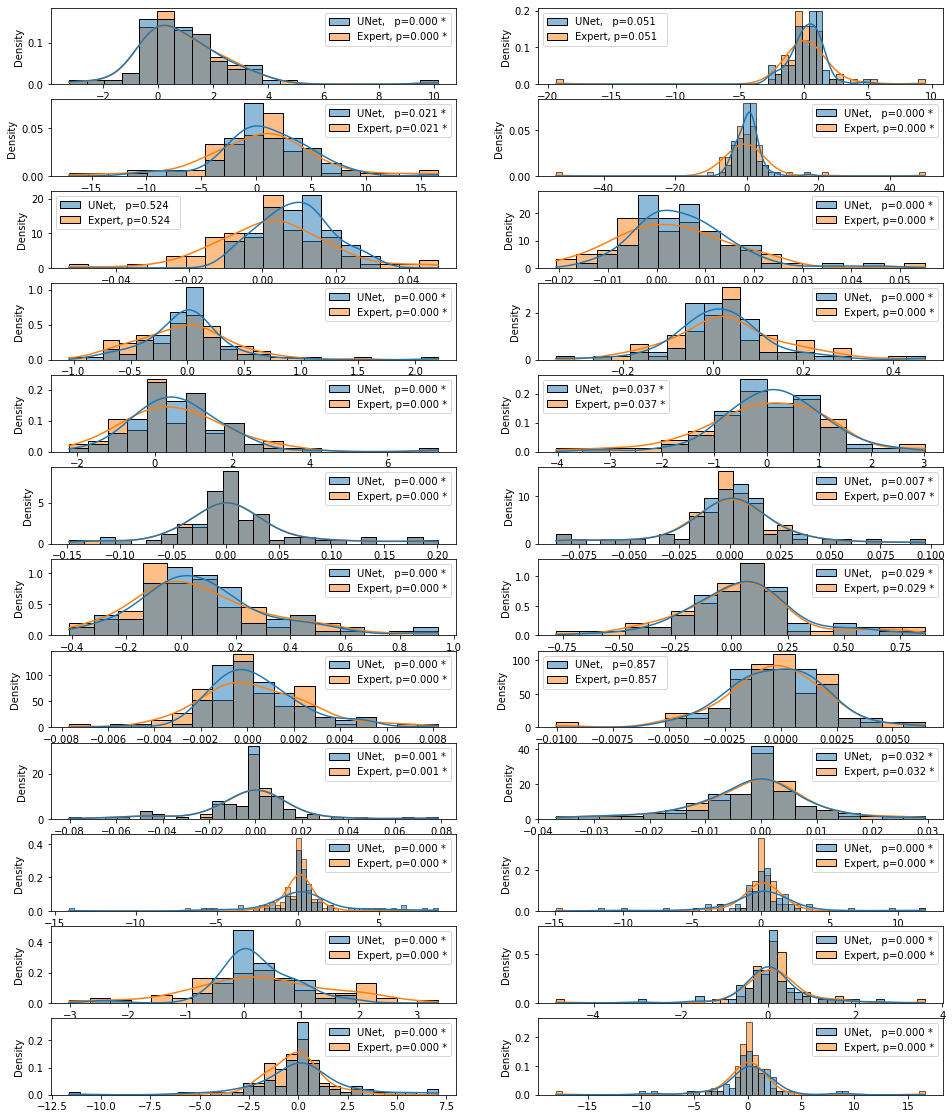

In [19]:
nrows = len(params_and_units)
ncols = len(site_dict)

fig, axs = plt.subplots(nrows, ncols, figsize=(16,20))

for (i, (k,v)) in enumerate(site_dict.items()):
    for (j, (param, unit)) in enumerate(params_and_units):
        
        diff = (
            df[df['Site']==k][f'Scan 1, {param} [{unit}]'].values
            - df[df['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )
        
        diff_expert = (
            df_expert[df_expert['Site']==k][f'Scan 1, {param} [{unit}]'].values
            - df_expert[df_expert['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )
        
        (_, unet_norm_p) = stats.normaltest(diff)
        unet_not_norm = '*' if unet_norm_p < alpha else ' '
        
        (_, expert_norm_p) = stats.normaltest(diff)
        expert_not_norm = '*' if expert_norm_p < alpha else ' '
        
        sns.histplot(
            ax=axs[j][i], 
            data={
                f'UNet,   p={unet_norm_p:0.3f} {unet_not_norm}': diff, 
                f'Expert, p={expert_norm_p:0.3f} {expert_not_norm}': diff_expert
            }, 
            stat='density', 
            kde=True
        )

The previous cell indicates that pretty much all of the data is not normally distributed. Therefore the t-tests for significant differences were invalid and we must instead use a Wilcoxon signed rank test.

In [20]:
alpha = 0.05

for (i, (k,v)) in enumerate(site_dict.items()):
    print('')
    for (j, (param, unit)) in enumerate(params_and_units):

        # test for significant differences
        
        sd = calculate_individual_standard_deviations(
            df[df['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df[df['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )
        
        df_pred_temp = pd.DataFrame.from_dict(
            {
                "ID": df[df["Site"]==k]["ID"].values,
                "SD, pred": sd
            }
        )

        sd_expert = calculate_individual_standard_deviations(
            df_expert[df_expert['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df_expert[df_expert['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )
        
        df_expert_temp = pd.DataFrame.from_dict(
            {
                "ID": df_expert[df_expert['Site']==k]["ID"].values,
                "SD, expert": sd_expert
            }
        )
        
        df_combined_temp = pd.merge(df_pred_temp, df_expert_temp,on="ID")
        
        (_, p_val) = stats.wilcoxon(df_combined_temp["SD, pred"],df_combined_temp["SD, expert"])
        
        diff_sig = "*" if p_val < alpha else " "
        print(f"{v:6s} | {param:10s}| diff p: {p_val:.3f} {diff_sig:s}")
        
print('')
print('Difference test | H0: no significant difference in mean   | Ha: significant difference in mean')


Tibia  | Tt.BMD    | diff p: 0.796  
Tibia  | Ct.BMD    | diff p: 0.010 *
Tibia  | Ct.Th     | diff p: 0.781  
Tibia  | Ct.Po     | diff p: 0.001 *
Tibia  | Tb.BMD    | diff p: 0.055  
Tibia  | Tb.N      | diff p: 0.030 *
Tibia  | Tb.BV/TV  | diff p: 0.030 *
Tibia  | Tb.Th     | diff p: 0.005 *
Tibia  | Tb.Sp     | diff p: 0.036 *
Tibia  | Tt.Ar     | diff p: 0.000 *
Tibia  | Ct.Ar     | diff p: 0.000 *
Tibia  | Tb.Ar     | diff p: 0.284  

Radius | Tt.BMD    | diff p: 0.639  
Radius | Ct.BMD    | diff p: 0.000 *
Radius | Ct.Th     | diff p: 0.333  
Radius | Ct.Po     | diff p: 0.045 *
Radius | Tb.BMD    | diff p: 0.016 *
Radius | Tb.N      | diff p: 0.246  
Radius | Tb.BV/TV  | diff p: 0.560  
Radius | Tb.Th     | diff p: 0.460  
Radius | Tb.Sp     | diff p: 0.497  
Radius | Tt.Ar     | diff p: 0.000 *
Radius | Ct.Ar     | diff p: 0.991  
Radius | Tb.Ar     | diff p: 0.000 *

Difference test | H0: no significant difference in mean   | Ha: significant difference in mean


In [21]:


for k,v in site_dict.items():
    
    print('='*hlinelength)
    print(f" RMS%CV (95% C.I.); {v}, N = {len(df[df['Site']==k])}")
    print('='*hlinelength)
    print('Parameter | UNet  | Expert | Diff')
    print('='*hlinelength)

    for param_and_unit in params_and_units:

        param = param_and_unit[0]
        unit = param_and_unit[1]

        RMS_CV, LSC = calculate_two_way_RMS_CV(
            df[df['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df[df['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )

        RMS_CV_expert, LSC_expert = calculate_two_way_RMS_CV(
            df_expert[df_expert['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df_expert[df_expert['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )
        
        diff = RMS_CV_expert - RMS_CV


        print(f'{param:9s} | {RMS_CV:5.2f} | {RMS_CV_expert:6.2f} | {diff:5.2f}')
    
    print('='*hlinelength)
    print('')

 RMS%CV (95% C.I.); Tibia, N = 85
Parameter | UNet  | Expert | Diff
Tt.BMD    |  0.47 |   0.48 |  0.01
Ct.BMD    |  0.36 |   0.45 |  0.09
Ct.Th     |  0.61 |   0.74 |  0.14
Ct.Po     |  9.07 |  11.67 |  2.60
Tb.BMD    |  0.61 |   0.69 |  0.08
Tb.N      |  2.97 |   2.98 |  0.01
Tb.BV/TV  |  0.83 |   0.82 | -0.01
Tb.Th     |  0.56 |   0.67 |  0.12
Tb.Sp     |  2.21 |   2.21 |  0.00
Tt.Ar     |  0.27 |   0.13 | -0.13
Ct.Ar     |  0.37 |   0.66 |  0.29
Tb.Ar     |  0.29 |   0.16 | -0.13

 RMS%CV (95% C.I.); Radius, N = 71
Parameter | UNet  | Expert | Diff
Tt.BMD    |  0.29 |   0.70 |  0.40
Ct.BMD    |  0.27 |   0.79 |  0.52
Ct.Th     |  0.69 |   0.80 |  0.11
Ct.Po     |  7.92 |   9.55 |  1.63
Tb.BMD    |  0.51 |   0.61 |  0.11
Tb.N      |  1.40 |   1.41 |  0.01
Tb.BV/TV  |  1.00 |   1.06 |  0.06
Tb.Th     |  0.63 |   0.72 |  0.09
Tb.Sp     |  1.06 |   1.07 |  0.01
Tt.Ar     |  0.71 |   0.77 |  0.05
Ct.Ar     |  0.76 |   1.17 |  0.41
Tb.Ar     |  0.79 |   1.27 |  0.49



Supplemental / Appendix data

In [22]:
# define a function for calculating two-way RMS SD
def calculate_two_way_RMS_SD(data1,data2):
    data1, data2 = np.asarray(data1), np.asarray(data2)
    data_mean = (1/2)*(data1 + data2)
    data_stdev = np.sqrt((data1 - data_mean)**2 + (data2 - data_mean)**2)
    return np.sqrt(np.mean(data_stdev**2))

In [24]:
site_dict = {'T': 'Tibia', 'R': 'Radius'}

for k,v in site_dict.items():
    
    print('='*hlinelength)
    print(f" {v}, N = {len(df[df['Site']==k])}")
    print('='*hlinelength)
    print('Parameter | RMS SD: UNet, Expert')
    print('='*hlinelength)

    for param_and_unit in params_and_units:

        param = param_and_unit[0]
        unit = param_and_unit[1]

        RMS_SD = calculate_two_way_RMS_SD(
            df[df['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df[df['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )

        RMS_SD_expert = calculate_two_way_RMS_SD(
            df_expert[df_expert['Site']==k][f'Scan 1, {param} [{unit}]'].values,
            df_expert[df_expert['Site']==k][f'Scan 2, {param} [{unit}]'].values
        )


        print(f'{param:9s} |     {RMS_SD:5.5f},  {RMS_SD_expert:5.5f}')
    
    print('='*hlinelength)
    print('')

 Tibia, N = 85
Parameter | RMS SD: UNet, Expert
Tt.BMD    |     1.34142,  1.34946
Ct.BMD    |     3.02175,  3.78118
Ct.Th     |     0.00935,  0.01145
Ct.Po     |     0.27454,  0.29541
Tb.BMD    |     1.00754,  1.10562
Tb.N      |     0.04053,  0.04061
Tb.BV/TV  |     0.18127,  0.18795
Tb.Th     |     0.00146,  0.00176
Tb.Sp     |     0.01630,  0.01628
Tt.Ar     |     2.03091,  0.98954
Ct.Ar     |     0.50900,  0.87411
Tb.Ar     |     1.77748,  0.96834

 Radius, N = 71
Parameter | RMS SD: UNet, Expert
Tt.BMD    |     0.90752,  2.01971
Ct.BMD    |     2.40681,  6.90202
Ct.Th     |     0.00809,  0.00919
Ct.Po     |     0.08124,  0.08853
Tb.BMD    |     0.67588,  0.85367
Tb.N      |     0.02059,  0.02068
Tb.BV/TV  |     0.18390,  0.19520
Tb.Th     |     0.00146,  0.00171
Tb.Sp     |     0.00776,  0.00798
Tt.Ar     |     2.23822,  1.81005
Ct.Ar     |     0.52810,  0.64322
Tb.Ar     |     1.92945,  2.27071

